# Imports

In [2]:
import pandas as pd
import numpy as np
import catboost as cb
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV
from scipy.stats.distributions import expon
from scipy.stats import uniform
from sklearn.metrics import ConfusionMatrixDisplay
import os
import glob
import re
import h2o
from h2o.automl import H2OAutoML

from tqdm import tqdm
import pickle
from autoxgb import AutoXGB
from autoxgb.cli.predict import PredictAutoXGBCommand

%matplotlib inline
rng = np.random.RandomState(42)

# Functions

In [3]:
def look_at_anti_dist(all_ASR, col_name, col_order=None):
    col_dist = all_ASR.groupby(by='antibiotic_name')[col_name].apply(lambda x: x.value_counts()).reset_index()
    col_dist.columns = ['antibiotic_name', col_name, 'count']
    order = col_dist.groupby(by='antibiotic_name')['count'].apply(sum).sort_values().index
    col_dist = pd.pivot_table(col_dist, values='count', index=['antibiotic_name'],
                    columns=[col_name], aggfunc=np.sum).fillna(0)
    if col_order is not None:
        col_dist = col_dist[col_order]
    ax = col_dist.loc[order].plot.barh(stacked=True, rot=0, figsize=(20,15))
    plt.title('Distribution of ' + col_name+' for each anti-biotics')
    plt.ylabel('antibiotics')
    plt.xlabel('# of measurements')
    plt.legend(loc='lower right')

In [4]:
def print_anti_measure(all_ASR, anti_index):
    anti = all_ASR['antibiotic_name'].value_counts().index[anti_index]
    anti_MIC = all_ASR[all_ASR['antibiotic_name'] == anti]
    anti_MIC['measurement'] = anti_MIC['measurement'].apply(np.log2)
    low = anti_MIC['measurement'].min().round()
    high = anti_MIC['measurement'].max().round()
    hist_range = np.arange(low-0.5, high+1, 1)
    bins_count = pd.DataFrame(anti_MIC.groupby(by='measurement_sign')['measurement'].apply(lambda x: np.histogram(x, bins=hist_range)[0]))
    bins_count = bins_count.merge(pd.DataFrame({'fill': [np.zeros(len(hist_range)-1)]}, index=['=', '<=', '>=', '<', '>']), left_index=True, right_index=True, how='right')
    bins_count['measurement'].fillna(bins_count['fill'], inplace=True)
    pd.DataFrame(bins_count['measurement'].tolist(), index= bins_count.index, columns=hist_range[:-1]+0.5).T.plot.bar(stacked=True)
    plt.title(anti)
    plt.xlabel('log2(mg//L)')
    plt.ylabel('#')


In [29]:
filtered_ASR['antibiotic_name'].value_counts()

tobramycin                       643
ceftriaxone                      643
gentamicin                       643
trimethoprim-sulfamethoxazole    643
ciprofloxacin                    643
levofloxacin                     642
ceftazidime                      642
tetracycline                     640
imipenem                         633
ampicillin-sulbactam             633
amikacin                         632
ampicillin                       600
cefazolin                        600
aztreonam                        599
nitrofurantoin                   591
cefotaxime                       585
cefoxitin                        435
meropenem                        325
tigecycline                      214
doripenem                        160
cefotetan                         98
moxifloxacin                      77
cefepime                          55
piperacillin-tazobactam           48
colistin                          47
polymyxin b                       43
minocycline                       33
a

In [30]:
anti_list = filtered_ASR['antibiotic_name'].value_counts().index.values

In [31]:
anti_list

array(['tobramycin', 'ceftriaxone', 'gentamicin',
       'trimethoprim-sulfamethoxazole', 'ciprofloxacin', 'levofloxacin',
       'ceftazidime', 'tetracycline', 'imipenem', 'ampicillin-sulbactam',
       'amikacin', 'ampicillin', 'cefazolin', 'aztreonam',
       'nitrofurantoin', 'cefotaxime', 'cefoxitin', 'meropenem',
       'tigecycline', 'doripenem', 'cefotetan', 'moxifloxacin',
       'cefepime', 'piperacillin-tazobactam', 'colistin', 'polymyxin b',
       'minocycline', 'amoxicillin-clavulanic acid', 'ertapenem',
       'cefuroxime', 'ticarcillin-clavulanic acid'], dtype=object)

In [32]:
filtered_ASR.set_index('biosample_id', inplace=True)

## set general data columns

In [33]:
data.set_index('biosample_id', inplace=True)

In [34]:
data.columns

Index(['Unnamed: 0', 'species_fam', 'run_id', 'sulfisoxazole', 'ampicillin',
       'chloramphenicol', 'tetracycline', 'amoxicillin-clavulanic acid',
       'azithromycin', 'nalidixic acid',
       ...
       'OXA-132->seq_id', 'OXA-132->seq_cov', 'OKP-B-7->seq_id',
       'OKP-B-7->seq_cov', 'dfrA21->seq_id', 'dfrA21->seq_cov',
       'CMY-111->seq_id', 'CMY-111->seq_cov', 'mefE->seq_id', 'mefE->seq_cov'],
      dtype='object', length=1288)

In [36]:
data.drop(['Unnamed: 0', 'species_fam', 'run_id'], axis=1, inplace=True)

In [37]:
data

,sulfisoxazole,ampicillin,chloramphenicol,tetracycline,amoxicillin-clavulanic acid,azithromycin,nalidixic acid,cefoxitin,ceftiofur,gentamicin,...,OXA-132->seq_id,OXA-132->seq_cov,OKP-B-7->seq_id,OKP-B-7->seq_cov,dfrA21->seq_id,dfrA21->seq_cov,CMY-111->seq_id,CMY-111->seq_cov,mefE->seq_id,mefE->seq_cov
biosample_id,,,,,,,,,,,,,,,,,,,,,
SAMD00126359,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMD00126360,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMD00126362,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMD00126363,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMD00126364,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN05201745,<= 4.0,<= 0.0,= 2.0,> 5.0,<= 0.0,= 2.0,= 1.0,= 1.0,= -1.0,= -1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN05201746,= 6.0,<= 0.0,= 2.0,<= 2.0,<= 0.0,= 2.0,= 2.0,= 1.0,= 0.0,<= -2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN05201749,> 8.0,> 5.0,= 3.0,> 5.0,> 5.0,= 2.0,= 2.0,= 5.0,= 3.0,= -1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Building models

## order data per label

In [28]:
species_filter_index_list = [2]
antibiotic_index_list = [0]
naive = True
strip_range_train=False
train_time = 60
test_range=True
exp_describtion = 'fixed_dup_train_no_range'


In [ ]:
for species_filter_index in species_filter_index_list:
    for antibiotic_index in antibiotic_index_list:
        X, y, X_range, y_range, features, label, species = get_filtered_data(
            data = 'tot_filtered_data.csv', 
            features = 'final_features',
            ASR_data = 'filtered_ASR_data.csv', 
            species_sep = True, 
            species_filter_index=species_filter_index, 
            naive=naive, 
            strip_range_train=strip_range_train,
            test_range=test_range, 
            antibiotic_index=antibiotic_index,
            task='regression',
        )
        exp_name = '{}_{}_{}_for_{}_min'.format(species, label, exp_describtion, train_time/60)
        filtered_data = X.merge(y, left_index=True, right_index=True)
        train, test = train_test_split(filtered_data, test_size=0.2, random_state=42)
        train.to_csv('../resources/train_{}.csv'.format(exp_name))
        test.to_csv('../resources/test_{}.csv'.format(exp_name))
        X_range.to_csv('../resources/range_{}.csv'.format(exp_name))
        y_range.to_csv('../resources/y_range_{}.csv'.format(exp_name))
        pd.DataFrame({'features': features}).to_csv('../resources/features_{}.csv'.format(exp_name))
        pd.DataFrame({'label': [label]}).to_csv('../resources/label_{}.csv'.format(exp_name))
        
        # required parameters:
        train_filename = '../resources/train_{}.csv'.format(exp_name)
        output = '../experiments/{}'.format(exp_name)

        # optional parameters
        test_filename = '../resources/test_{}.csv'.format(exp_name)
        task = 'regression'
        idx = 'biosample_id'
        targets = [y.name]
        features = list(X.columns.values)
        categorical_features = None
        use_gpu = True
        num_folds = 5
        seed = 42
        num_trials = 100
        time_limit = train_time
        fast = False

        # Now its time to train the model!
        axgb = AutoXGB(
            train_filename=train_filename,
            output=output,
            test_filename=test_filename,
            task=task,
            idx=idx,
            targets=targets,
            features=features,
            categorical_features=categorical_features,
            use_gpu=use_gpu,
            num_folds=num_folds,
            seed=seed,
            num_trials=num_trials,
            time_limit=time_limit,
            fast=fast,
        )
        axgb.train()
        if test_range:
            PredictAutoXGBCommand('../experiments/{}'.format(exp_name), '../resources/range_{}.csv'.format(exp_name), '../experiments/{}/range_preds.csv'.format(exp_name)).execute()

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  del sys.path[0]
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  del sys.path[0]
2022-02-01 03:04:27.517 | INFO     | autoxgb.autoxgb:__post_init__:42 - Output directory: ../experiments/ecoli_amoxicillin-clavulanic acid_fixed_dup_train_no_range_for_60.0_min
2022-02-01 03:04:27.518 | INFO     | autoxgb.autoxgb:_process_data:149 - Reading training data
2022-02-01 03:04:27.643 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.04 Mb (74.6% reduction

## playing with autoxgb

In [6]:
model_param = {
    'model': 'autoxgb',
    'num_models':  100,
    'time_limit':  3600,
}

In [11]:
exp_names_strip = [exp_name[:-12]+'_striped_range_strat' for exp_name in exp_names]
exp_names_dist_2 = [exp_name[:-12]+'_distanced_range2_strat' for exp_name in exp_names]
exp_names_dist_5 = [exp_name[:-12]+'_distanced_range5_strat' for exp_name in exp_names]

In [12]:
for exp_name in tqdm(exp_names_strip+exp_names_dist_2+exp_names_dist_5):
    # required parameters:
    model_name = '_'.join(['_'.join([k,str(v)]) for k,v in model_param.items()])
    train_filename = '../experiments/{}/train.csv'.format(exp_name)
    output = '../experiments/{}/{}'.format(exp_name, model_name)
    features = list(pd.read_csv('../experiments/{}/features.csv'.format(exp_name))['features'].values)
    targets = [pd.read_csv('../experiments/{}/label.csv'.format(exp_name)).loc[0, 'label']]
    pd.DataFrame(model_param).to_csv(output+'/model_param.csv')

    # optional parameters
    test_filename = '../experiments/{}/test.csv'.format(exp_name)
    task = 'regression'
    idx = 'biosample_id'
    categorical_features = None
    use_gpu = True
    num_folds = 5
    seed = 42
    fast = False

    # Now its time to train the model!
    axgb = AutoXGB(
        train_filename=train_filename,
        output=output,
        test_filename=test_filename,
        task=task,
        idx=idx,
        targets=targets,
        features=features,
        categorical_features=categorical_features,
        use_gpu=use_gpu,
        num_folds=num_folds,
        seed=seed,
        num_trials=model_param['num_models'],
        time_limit=model_param['time_limit'],
        fast=fast,
    )
    axgb.train()
    PredictAutoXGBCommand(exp_name, '../experiments/{}/X_range.csv'.format(exp_name), '{}/range_preds.csv'.format(output)).execute()

  0%|          | 0/30 [00:00<?, ?it/s]2022-03-14 01:41:25.958 | INFO     | autoxgb.autoxgb:__post_init__:42 - Output directory: ../experiments/abaumannii_tobramycin_striped_range_strat/model_autoxgb_num_trials_100_time_limit_3600
2022-03-14 01:41:25.959 | INFO     | autoxgb.autoxgb:_process_data:149 - Reading training data
2022-03-14 01:41:26.200 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.20 Mb (74.6% reduction)
2022-03-14 01:41:26.202 | INFO     | autoxgb.autoxgb:_determine_problem_type:140 - Problem type: single_column_regression
2022-03-14 01:41:26.415 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.05 Mb (74.6% reduction)
2022-03-14 01:41:26.416 | INFO     | autoxgb.autoxgb:_create_folds:58 - Creating folds
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/autoxgb/autoxgb.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

In [19]:
axgb.

AutoXGB(train_filename='../experiments/abaumannii_tobramycin_naive_strat/train.csv', output='../experiments/abaumannii_tobramycin_naive_strat/model_autoxgb_num_trials_100_time_limit_3600', test_filename='../experiments/abaumannii_tobramycin_naive_strat/test.csv', task='regression', idx='biosample_id', targets=['tobramycin'], features=['tet(A)->seq_id', 'PER-1->seq_cov', 'ADC-58->seq_id', 'ADC-30->seq_id', 'OXA-69->seq_cov', 'ADC-30->seq_cov', 'ADC-79->seq_cov', 'ADC-25->seq_cov', 'acrD->seq_id', 'adeH->seq_id', 'dfrA1->seq_cov', 'aadA17->seq_id', 'adeK->seq_cov', 'TEM-12->seq_cov', 'acrF->seq_id', 'determinant_of_bleomycin_resistance->seq_id', 'adeK->seq_id', "AAC(6')-Ian->seq_id", 'OXA-340->seq_cov', "ANT(3'')-IIb->seq_id", 'aadA27->seq_id', 'cmeB->seq_cov', 'AAC(3)-IIe->seq_id', 'mphE->seq_id', 'ADC-2->seq_id', 'Acinetobacter_baumannii_AmvA->seq_id', 'OXA-407->seq_cov', "APH(3')-Ia->seq_id", 'adeL->seq_id', 'CMY-59->seq_cov', 'adeF->seq_cov', 'OXA-113->seq_cov', 'OXA-100->seq_id', 'f

In [273]:
PredictAutoXGBCommand(exp_name, '../resources/range_{}.csv'.format(exp_name), '{}/range_preds.csv'.format(exp_name)).execute()

2022-01-25 15:24:27.763 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 1.10 Mb (74.7% reduction)


### Fill in range predictions

In [4]:
def walk_level(some_dir, level=1):
    some_dir = some_dir.rstrip(os.path.sep)
    assert os.path.isdir(some_dir)
    num_sep = some_dir.count(os.path.sep)
    for root, dirs, files in os.walk(some_dir):
        yield root, dirs, files
        num_sep_this = root.count(os.path.sep)
        if num_sep + level <= num_sep_this:
            del dirs[:]

In [6]:
exp_dir_path = '../experiments/'
results = pd.DataFrame({})
for path in os.listdir(exp_dir_path):
    data_param_path = exp_dir_path+path+'/data_param.csv'
    if not os.path.exists(data_param_path):
        continue
    data_param = pd.read_csv(data_param_path)
    x = next(walk_level(exp_dir_path+path))
    for model_dir in x[1]:
        if '.ipynb' in model_dir:
            continue
        if os.path.exists(exp_dir_path+path+'/'+model_dir+'/model_param.csv'):
            pass
        else:
            model_name = model_dir.split('_')[1]
            if model_name == 'autoxgb':
                num_models = model_dir.split('_')[4]
                time_limit = model_dir.split('_')[7]
            else:
                continue
            PredictAutoXGBCommand(exp_dir_path+path+'/'+model_dir, 
                                  '{}/X_range.csv'.format(exp_dir_path+path),
                                  '{}/range_preds.csv'.format(exp_dir_path+path+'/'+model_dir)
            ).execute()



2022-03-15 12:52:42.487 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.18 Mb (74.6% reduction)
2022-03-15 12:52:53.684 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.20 Mb (74.6% reduction)
2022-03-15 12:52:54.192 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.16 Mb (74.5% reduction)
2022-03-15 12:52:54.738 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.15 Mb (74.5% reduction)
2022-03-15 12:52:55.339 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.16 Mb (74.4% reduction)
2022-03-15 12:52:55.957 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.20 Mb (74.6% reduction)
2022-03-15 12:52:56.481 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.18 Mb (74.6% reduction)
2022-03-15 12:52:56.998 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.20 Mb (74.6% red

### exact results

In [177]:
# exp_name = 'largest_species_and_anti_train_striped_range_60min'

In [288]:
label = pd.read_csv('../resources/label_{}.csv'.format(exp_name)).loc[0, 'label']
y_range = pd.read_csv('../resources/y_range_{}.csv'.format(exp_name)).set_index('unique_id')

In [289]:
y = pd.read_csv('../resources/train_{}.csv'.format(exp_name)).set_index('unique_id')[label]
train_res = pd.read_csv('../notebooks/{}/oof_predictions.csv'.format(exp_name)).set_index('unique_id').merge(y, left_index=True, right_index=True, how='inner')
train_res = train_res.loc[set(train_res.index)-set(y_range.index)]
train_res.columns=['y_pred', 'y_true']
train_res['y_true'] = np.round(train_res['y_true'])
min_true = train_res['y_true'].min()
max_true = train_res['y_true'].max(axis=0)
train_res['y_pred'] = train_res['y_pred'].clip(lower=min_true, upper=max_true)
train_res['residual'] = train_res['y_true'] - train_res['y_pred']
train_res['y_pred'] = np.round(train_res['y_pred'])
train_res['round_residual'] = train_res['y_true'] - train_res['y_pred']
train_res.describe()

,y_pred,y_true,residual,round_residual
count,588.000000,588.000000,588.000000,588.000000
mean,-4.636054,-4.596939,0.054976,0.039116
std,0.875675,0.998700,0.593355,0.586765
min,-5.000000,-6.000000,-3.785749,-4.000000
25%,-5.000000,-5.000000,-0.035029,0.000000
50%,-5.000000,-5.000000,0.024032,0.000000
75%,-5.000000,-5.000000,0.063181,0.000000
max,1.000000,1.000000,4.481135,4.000000


In [290]:
y = pd.read_csv('../resources/test_{}.csv'.format(exp_name)).set_index('unique_id')[label]
test_res = pd.read_csv('../notebooks/{}/test_predictions.csv'.format(exp_name)).set_index('unique_id').merge(y, left_index=True, right_index=True, how='inner')
test_res = test_res.loc[set(test_res.index)-set(y_range.index)]
test_res.columns=['y_pred', 'y_true']
test_res['y_true'] = np.round(test_res['y_true'])
min_true = test_res['y_true'].min()
max_true = test_res['y_true'].max(axis=0)
test_res['y_pred'] = test_res['y_pred'].clip(lower=min_true, upper=max_true)
test_res['residual'] = test_res['y_true'] - test_res['y_pred']
test_res['y_pred'] = np.round(test_res['y_pred'])
test_res['round_residual'] = test_res['y_true'] - test_res['y_pred']
test_res.describe()

,y_pred,y_true,residual,round_residual
count,148.000000,148.000000,148.000000,148.000000
mean,-4.621622,-4.513514,0.100925,0.108108
std,0.722857,1.065772,0.864756,0.912015
min,-5.000000,-5.000000,-3.730136,-4.000000
25%,-5.000000,-5.000000,-0.027872,0.000000
50%,-5.000000,-5.000000,0.000000,0.000000
75%,-4.000000,-4.000000,0.000000,0.000000
max,-1.000000,1.000000,3.971889,4.000000


In [291]:
for key, res in {'Train': train_res, 'Test': test_res}.items():
    print(key)
    print('RMSE: {}'.format(res['residual'].std()))
    print('RMSE after rounding: {}'.format(res['round_residual'].std()))

Train
RMSE: 0.5933550724787763
RMSE after rounding: 0.5867653660368267
Test
RMSE: 0.86475562201035
RMSE after rounding: 0.9120145536427916


In [292]:
regression_res = pd.DataFrame({
    'exact RMSE': [train_res['residual'].std(), test_res['residual'].std()],
    'exact_rounded RMSE': [train_res['round_residual'].std(), test_res['round_residual'].std()],
}, index=['train', 'test'])
regression_res

,exact RMSE,exact_rounded RMSE
train,0.593355,0.586765
test,0.864756,0.912015


<IPython.core.display.Javascript object>


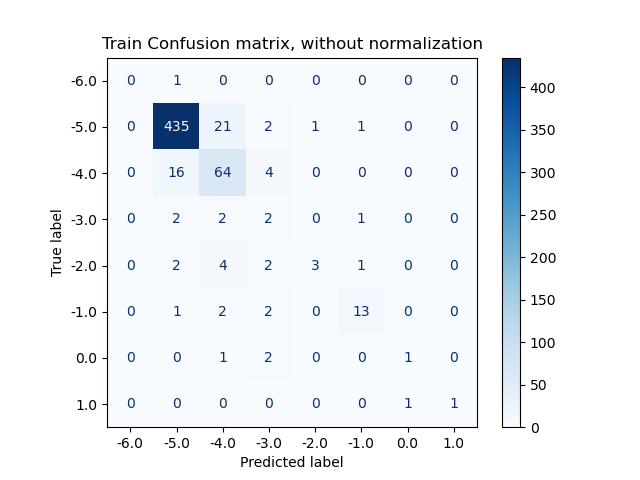

<IPython.core.display.Javascript object>


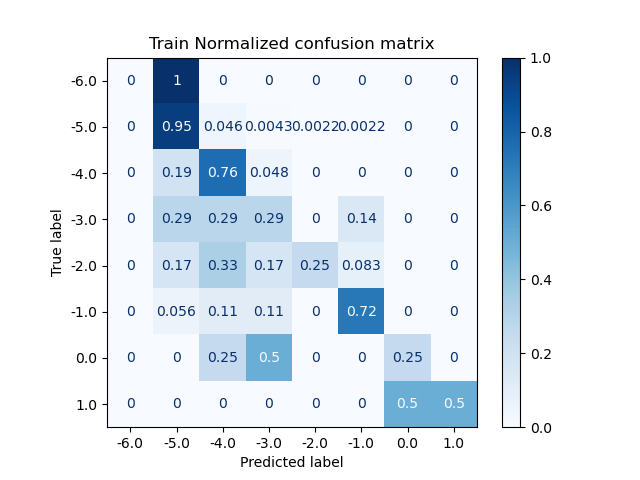

<IPython.core.display.Javascript object>


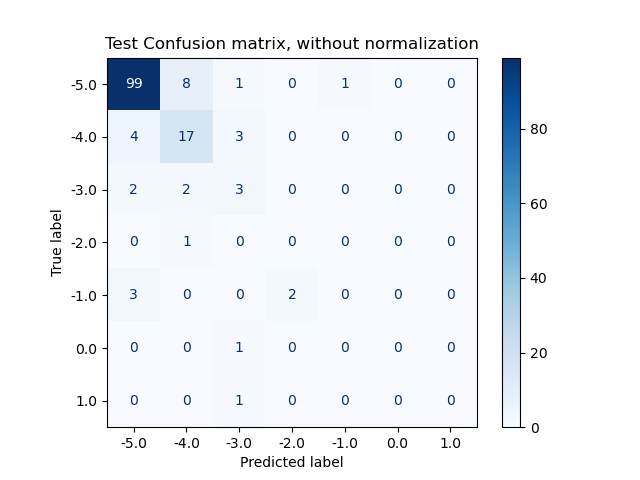

<IPython.core.display.Javascript object>


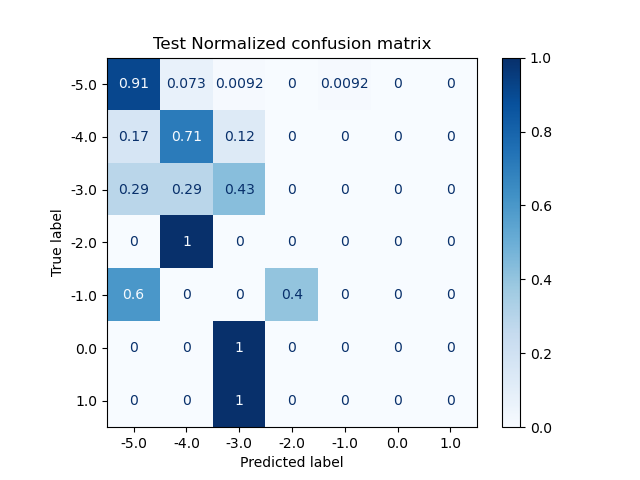

In [293]:
for key, res in {'Train': train_res, 'Test': test_res}.items():
    titles_options = [
        (key+ " Confusion matrix, without normalization", None),
        (key+" Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_predictions(
            np.round(res['y_true']),
            res['y_pred'],
            labels=np.sort(list(set(list(np.round(res['y_true']).unique())).union(set(list(np.round(res['y_pred']).unique()))))),
    #         display_labels=np.sort(list(train_res['y_true'].unique())),
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
        cm = pd.DataFrame(disp.confusion_matrix, index=disp.display_labels, columns=disp.display_labels)
        cm.columns.name='predicted_labels'
        cm.index.name='true_labels'
        cm.to_csv('../notebooks/{}/{}_df_confusion_matrix_{}.csv'.format(exp_name, key, normalize))
        plt.savefig('../notebooks/{}/{}_confusion_matrix_{}.png'.format(exp_name, key, normalize), format='png')
plt.show()

### range result

In [294]:
equal_meaning = True

In [295]:
range_res = pd.read_csv('../notebooks/{}/range_preds.csv'.format(exp_name)).set_index('unique_id').merge(y_range, left_index=True, right_index=True, how='inner')
range_res.columns=['y_pred'] + list(range_res.columns.values)[1:]
range_res['values'] = np.round(range_res['values'])
range_res['updated_values'] = np.nan
range_res['updated_direction'] = np.nan
if equal_meaning:
        range_res.loc[range_res['direction'] == '>=','updated_values'] = range_res['values'] - 1
        range_res.loc[range_res['direction'] == '<=','updated_values'] = range_res['values'] + 1
range_res.loc[range_res['direction'] == '>=','updated_direction'] = '>'
range_res.loc[range_res['direction'] == '<=','updated_direction'] = '<'

range_res.loc[:,'updated_values'].fillna(range_res['values'], inplace=True)
range_res.loc[:,'updated_direction'].fillna(range_res['direction'], inplace=True)

range_res.loc[range_res['updated_direction'] == '>','answer'] = (range_res['y_pred'] > range_res['updated_values'])
range_res.loc[range_res['updated_direction'] == '<','answer'] = (range_res['y_pred'] < range_res['updated_values'])
train_range_res = range_res.loc[set(range_res.index).intersection(set(train.index))]
test_range_res = range_res.loc[set(range_res.index) - set(train.index)]
for key, res in {'train': train_range_res, 'test': test_range_res}.items():
    range_confusion = res.groupby(by=['direction', 'values'])['answer'].agg(['count', 'sum']).replace(True, 1)
    range_confusion['perc'] = range_confusion['sum'] / range_confusion['count']
    range_confusion.columns = ['total', 'in range', 'accuracy']
    range_confusion = pd.DataFrame(range_confusion.stack()).T.swaplevel(i=2, j=0, axis=1)
    range_confusion.index=[key]
    regression_res = pd.concat([regression_res, range_confusion], axis=1)
regression_res_cleaned = pd.DataFrame({})
for col in regression_res.columns:
    if len(regression_res[[col]].columns) > 1:
        regression_res_cleaned[col] = regression_res[[col]].iloc[:,0].fillna(regression_res[[col]].iloc[:,1])
    else:
        regression_res_cleaned[col] = regression_res[[col]]
regression_res = regression_res_cleaned

In [298]:
regression_res

,exact RMSE,exact_rounded RMSE,"(total, -6.0, <)","(in range, -6.0, <)","(accuracy, -6.0, <)","(total, 2.0, >)","(in range, 2.0, >)","(accuracy, 2.0, >)"
train,0.593355,0.586765,NaN,NaN,NaN,NaN,NaN,NaN
test,0.864756,0.912015,2266,0,0.0,3,0,0.0


In [299]:
regression_res.to_csv('../notebooks/{}/df_regression_results.csv'.format(exp_name))

In [250]:
label

'ciprofloxacin'

## Playing with h2o

In [2]:
def get_filtered_data(
    data = 'tot_filtered_data.csv', 
    features = 'final_features',
    ASR_data = 'filtered_ASR_data.csv', 
    species_sep = True, 
    antibiotic_sep=True,
    species_filter_index=0, 
    antibiotic_index=0,
    naive=True, 
    task='regression', 
    strip_range_train=False,
    distance_range_train=False,
    range_moved=5,
    reg_stratified=True,
):
    data = pd.read_csv('../resources/'+data)
    with open("../resources/"+ features, "rb") as fp:
        features = pickle.load(fp)
    ASR_data = pd.read_csv('../resources/'+ASR_data)
    
    species2merge = data[['biosample_id', 'species_fam']]
    filtered_ASR = ASR_data.drop('species_fam', axis=1).merge(species2merge, on='biosample_id')
    filtered_ASR.set_index('biosample_id', inplace=True)
    filtered_ASR = filtered_ASR[filtered_ASR['units']=='mg/L']
    filtered_ASR = filtered_ASR[filtered_ASR['ast_standard']=='CLSI']
    filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='senterica']
    filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='spneumoniae']
    data.set_index('biosample_id', inplace=True)
    data.drop(['Unnamed: 0', 'species_fam', 'run_id'], axis=1, inplace=True)
            
    if species_sep:
        species = filtered_ASR['species_fam'].value_counts().reset_index()['index'].iloc[species_filter_index]
        filtered_ASR = filtered_ASR[filtered_ASR['species_fam'] == species]
    else:
        species = None
        
    if antibiotic_sep:
        anti_list = filtered_ASR['antibiotic_name'].value_counts().index.values
        label = anti_list[antibiotic_index]
        filtered_ASR = filtered_ASR[filtered_ASR['antibiotic_name'] == label]
    else:
        label = 'measurement'
    
    range_ASR = filtered_ASR[filtered_ASR['measurement_sign']!='=']        
    exact_ASR = filtered_ASR[filtered_ASR['measurement_sign']=='=']

    
    range_data_values = data.loc[range_ASR.index][label]
    range_labels = pd.DataFrame({
        'values':[],
        'direction': [],
    })
    range_labels['values'] = range_data_values.apply(lambda x: float(x.split(' ')[1]))
    range_labels['direction'] = range_data_values.apply(lambda x: x.split(' ')[0].replace('=', ''))
    
    exact_y = data.loc[exact_ASR.index][label]
    if task == 'regression':
        exact_y = exact_y.apply(lambda x: float(x.split(' ')[1]))
    elif task == 'classification':
        exact_y = exact_y.apply(lambda x: str(x.split(' ')[1]))
        
    exact_X = data.loc[exact_ASR.index][features]
    exact_X.dropna(axis=1, how='all', inplace=True)
    exact_X.fillna(0, inplace=True) 
    exact = exact_X.merge(exact_y, left_index=True, right_index=True)
    
    if not naive:
        range_y = range_data_values
        if task == 'regression':
            if strip_range_train:
                range_y = range_labels['values']
            elif distance_range_train:
                signs = range_labels['direction']
                range_y = range_labels['values']
                range_y = range_y.mask(signs == '>', range_y + range_moved)
                range_y = range_y.mask(signs == '<', range_y - range_moved)
            else:
                print('regression not in the naive approach is not implemented yet.') 
        range_y.name = label
    else:
        range_y = pd.DataFrame({})
        
    train_features = exact_X.columns.values
    range_X = data.loc[range_ASR.index][train_features]
    range_X.fillna(0, inplace=True)
    range_X = range_X.reset_index().set_index('biosample_id')
    range_data = range_X.merge(range_y, left_index=True, right_index=True)
    
    range_train_ids = []
    range_test_ids = []
    if reg_stratified:
        exact_train_ids = []
        exact_test_ids = []
        for y_val in set(exact_y.values):    
            sub_value_id = list(exact_y[exact_y == y_val].index)
            if len(sub_value_id) > 1:
                exact_train_id, exact_test_id = train_test_split(sub_value_id, test_size=0.2, random_state=42)
                exact_train_ids = exact_train_ids + exact_train_id
                exact_test_ids = exact_test_ids + exact_test_id
            else:
                exact_train_ids = exact_train_ids + sub_value_id
        if not naive:
            for y_val in set(range_y.values):    
                sub_value_id = list(range_y[range_y == y_val].index)
                if len(sub_value_id) > 1:
                    range_train_id, range_test_id = train_test_split(sub_value_id, test_size=0.2, random_state=42)
                    range_train_ids = range_train_ids + range_train_id
                    range_test_ids = range_test_ids + range_test_id
                else:
                    range_train_id = range_train_id + sub_value_id
    else:
        exact_train_ids, exact_test_ids = train_test_split(list(exact_y.index), test_size=0.2, random_state=42)
        if not naive:
            range_train_ids, range_test_ids = train_test_split(list(range_y.index), test_size=0.2, random_state=42)

    train = pd.concat([exact.loc[exact_train_ids,], range_data.loc[range_train_ids,]])
    test = pd.concat([exact.loc[exact_test_ids,], range_data.loc[range_test_ids,]])
    
    return train, test, range_X, range_labels, list(train_features), label, species

In [3]:
def run_h2o(model_param, exp_name):
    print(exp_name)
    # Import a sample binary outcome train/test set into H2O
    trainH2o = h2o.import_file('../experiments/{}/train.csv'.format(exp_name))
    print(trainH2o.as_data_frame().columns[-1])
    testH2o = h2o.import_file('../experiments/{}/test.csv'.format(exp_name))
    rangeH2o = h2o.import_file('../experiments/{}/X_range.csv'.format(exp_name))
    model_name = '_'.join(['_'.join([k,str(v)]) for k,v in model_param.items()])

    # Identify predictors and response
    x = list(pd.read_csv('../experiments/{}/features.csv'.format(exp_name))['features'].values)
    y = pd.read_csv('../experiments/{}/label.csv'.format(exp_name)).loc[0, 'label']
    
    # Run AutoML for 20 base models
    aml = H2OAutoML(max_models=model_param['max_models'], seed=42, max_runtime_secs=model_param['train_time'])
    aml.train(x=x, y=y, training_frame=trainH2o)

    # View the AutoML Leaderboard
    lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
    lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

    model = aml.leader
    model_path = h2o.save_model(model=model, path='../experiments/{}/{}/model'.format(exp_name, model_name), force=True)
    lb.as_data_frame().to_csv('../experiments/{}/{}/leader_board.csv'.format(exp_name, model_name))
    test_preds = model.predict(testH2o).as_data_frame()
    range_preds = model.predict(rangeH2o).as_data_frame()
    test_preds.to_csv('../experiments/{}/{}/test_preds.csv'.format(exp_name, model_name))
    range_preds.to_csv('../experiments/{}/{}/range_preds.csv'.format(exp_name, model_name))
    return aml

In [4]:
species_filter_index_list = [0]
antibiotic_index_list = np.arange(10)

data_param = {
    'naive': True,
    'strip_range_train': False,
    'distance_range_train': False,
    'reg_stratified': True,
    'species_sep': True,
    'antibiotic_sep': True,
    'exp_describtion': 'naive_strat',
}

In [5]:
exp_names = []
for species_filter_index in tqdm(species_filter_index_list):
    for antibiotic_index in tqdm(antibiotic_index_list):
        train, test, X_range, y_range, features, label, species = get_filtered_data(
            data = 'tot_filtered_data.csv', 
            features = 'final_features',
            ASR_data = 'filtered_ASR_data.csv', 
            species_filter_index=species_filter_index, 
            antibiotic_index=antibiotic_index,
            species_sep = data_param['species_sep'], 
            antibiotic_sep = data_param['antibiotic_sep'], 
            naive = data_param['naive'], 
            strip_range_train = data_param['strip_range_train'], 
            reg_stratified = data_param['reg_stratified'],
            distance_range_train = data_param['distance_range_train'],
            task='regression',
        )
        data_param['species'] = species
        data_param['antibiotic'] = label
        exp_name = '{}_{}_{}'.format(species, label, data_param['exp_describtion'])
        exp_names.append(exp_name)
        os.makedirs('../experiments/{}'.format(exp_name), exist_ok=True)
        train.to_csv('../experiments/{}/train.csv'.format(exp_name))
        test.to_csv('../experiments/{}/test.csv'.format(exp_name))
        X_range.to_csv('../experiments/{}/X_range.csv'.format(exp_name))
        y_range.to_csv('../experiments/{}/y_range.csv'.format(exp_name))
        pd.DataFrame({'features': features}).to_csv('../experiments/{}/features.csv'.format(exp_name))
        pd.DataFrame({'label': [label]}).to_csv('../experiments/{}/label.csv'.format(exp_name))
        pd.DataFrame(data_param, index=[0]).to_csv('../experiments/{}/data_param.csv'.format(exp_name))

  0%|          | 0/10 [00:00<?, ?it/s]/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()

100%|██████████| 1/1 [00:10<00:00, 10.51s/it]


In [6]:
exp_names

['abaumannii_tobramycin_naive_strat',
 'abaumannii_ceftriaxone_naive_strat',
 'abaumannii_gentamicin_naive_strat',
 'abaumannii_trimethoprim-sulfamethoxazole_naive_strat',
 'abaumannii_ciprofloxacin_naive_strat',
 'abaumannii_levofloxacin_naive_strat',
 'abaumannii_ceftazidime_naive_strat',
 'abaumannii_tetracycline_naive_strat',
 'abaumannii_imipenem_naive_strat',
 'abaumannii_ampicillin-sulbactam_naive_strat']

In [235]:
model_param= {
    'model': 'h2o',
    'train_time': 3600,
    'max_models': 100,
}

In [ ]:
# Start the H2O cluster (locally)
h2o.init()
for exp_name in tqdm(exp_names):
    a = run_h2o(model_param, exp_name)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 4 mins
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.1
H2O_cluster_version_age:,2 months and 12 days
H2O_cluster_name:,H2O_from_python_amitdanw_auth_ad_bgu_ac_il_rzifhm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.817 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


  0%|          | 0/10 [00:00<?, ?it/s]

abaumannii_tobramycin_naive_strat
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
tobramycin
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
20:29:47.626: _train param, Dropping bad and constant columns: [adeF->seq_cov, abeM->seq_cov, OXA-208->seq_id, adeI->seq_cov, mdsB->seq_id, mdsB->seq_cov, TEM-1->seq_id, adeJ->seq_cov, golS->seq_cov, adeK->seq_cov, adeB->seq_cov, TEM-1->seq_cov, golS->seq_id, OXA-208->seq_cov]


20:29:48.628: _train param, Dropping bad and constant columns: [adeF->seq_cov, abeM->seq_cov, OXA-208->seq_id, adeI->seq_cov, mdsB->seq_id, mdsB->seq_cov, TEM-1->seq_id, adeJ->seq_cov, golS->seq_cov, adeK->seq_cov, adeB->seq_cov, TEM-1->seq_cov, golS->seq_id, OXA-208->seq_cov]

█
20:29:49.629: _train param, Dropping bad and constant columns: [adeF->seq_cov, abeM->seq_c

 10%|█         | 1/10 [44:02<6:36:22, 2642.49s/it]

███████████████████████████████████████████| (done) 100%
abaumannii_ceftriaxone_naive_strat
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
ceftriaxone
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:13:50.177: _train param, Dropping bad and constant columns: [adeF->seq_cov, OXA-413->seq_cov, OXA-413->seq_id, abeM->seq_cov, adeJ->seq_cov]


21:13:51.180: _train param, Dropping bad and constant columns: [adeF->seq_cov, OXA-413->seq_cov, OXA-413->seq_id, abeM->seq_cov, adeJ->seq_cov]

█
21:13:52.183: _train param, Dropping bad and constant columns: [adeF->seq_cov, OXA-413->seq_cov, OXA-413->seq_id, abeM->seq_cov, adeJ->seq_cov]
21:13:52.183: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 49.0.
21:

 20%|██        | 2/10 [1:15:38<4:53:48, 2203.59s/it]

██████████████████████████████████████████████| (done) 100%
abaumannii_gentamicin_naive_strat
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gentamicin
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:45:26.465: _train param, Dropping bad and constant columns: [adeF->seq_cov, abeM->seq_cov, adeI->seq_cov, adeK->seq_cov, Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_cov, abeS->seq_cov, adeJ->seq_cov]


21:45:27.467: _train param, Dropping bad and constant columns: [adeF->seq_cov, abeM->seq_cov, adeI->seq_cov, adeK->seq_cov, Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_cov, abeS->seq_cov, adeJ->seq_cov]

█
21:45:28.469: _train param, Dropping bad and constant columns: [adeF->seq_cov, abeM->seq_cov, adeI->seq_cov, adeK->seq

 30%|███       | 3/10 [1:46:04<3:56:58, 2031.17s/it]

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
abaumannii_trimethoprim-sulfamethoxazole_naive_strat
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
trimethoprim-sulfamethoxazole
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
22:15:52.503: _train param, Dropping bad and constant columns: [adeF->seq_cov, abeM->seq_cov, adeI->seq_cov, adeK->seq_cov, Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_cov, adeH->seq_cov, adeB->seq_cov, abeS->seq_cov, adeJ->seq_cov, adeA->seq_cov]


22:15:53.506: _train param, Dropping bad and constant columns: [adeF->seq_cov, abeM->seq_cov, adeI->seq_cov, adeK->seq_cov, Bifidobacterium_ad

 40%|████      | 4/10 [2:33:19<3:54:50, 2348.45s/it]

███████████████████████████████████████████| (done) 100%
abaumannii_ciprofloxacin_naive_strat
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
ciprofloxacin
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
23:03:07.368: _train param, Dropping bad and constant columns: [mdsB->seq_id, mdsB->seq_cov, adeJ->seq_cov, OXA-58->seq_id, OXA-64->seq_cov, adeK->seq_cov, Bifidobacterium_adolescentis_rpoB_conferring_resistance_to_rifampicin->seq_cov, adeH->seq_cov, OXA-58->seq_cov, ADC-11->seq_cov, OXA-64->seq_id, cmeB->seq_id, golS->seq_id, OXA-340->seq_cov, OXA-340->seq_id, adeF->seq_cov, adeL->seq_cov, abeM->seq_cov, adeI->seq_cov, acrF->seq_cov, OXA-69->seq_cov, acrF->seq_id, cmeB->seq_cov, abeS->seq_cov, mphE->seq_cov, ADC-11->seq_id, golS->seq_cov, msrE->seq_cov, OXA-69->seq_id, msrE->seq_i

In [180]:
a.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_8_20220312_193830


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,40.0,40.0,13990.0,7.0,10.0,9.025,15.0,26.0,23.125




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.20165293063200607
RMSE: 0.44905782548799444
MAE: 0.27867097588730794
RMSLE: 0.18654265398550238
Mean Residual Deviance: 0.20165293063200607

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.42128403337603865
RMSE: 0.6490639670911016
MAE: 0.3894030091492372
RMSLE: 0.2751771224529029
Mean Residual Deviance: 0.42128403337603865

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.388307,0.035306,0.411217,0.423247,0.340666,0.361770,0.404635
1,mean_residual_deviance,0.428045,0.081105,0.468268,0.481188,0.305650,0.385690,0.499428
2,mse,0.428045,0.081105,0.468268,0.481188,0.305650,0.385690,0.499428
3,r2,0.679884,0.058440,0.652407,0.648065,0.769917,0.705229,0.623802
4,residual_deviance,0.428045,0.081105,0.468268,0.481188,0.305650,0.385690,0.499428
5,rmse,0.651715,0.064343,0.684301,0.693677,0.552856,0.621039,0.706702
6,rmsle,0.276708,0.033211,0.303092,0.310871,0.237174,0.246645,0.285756



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-03-12 19:38:53,2.728 sec,0.0,1.155973,0.970588,1.336275
1,,2022-03-12 19:38:53,2.805 sec,5.0,0.829679,0.660368,0.688367
2,,2022-03-12 19:38:53,2.895 sec,10.0,0.671773,0.494462,0.451279
3,,2022-03-12 19:38:53,2.981 sec,15.0,0.575508,0.391525,0.331210
4,,2022-03-12 19:38:53,3.058 sec,20.0,0.526892,0.344018,0.277615
5,,2022-03-12 19:38:53,3.152 sec,25.0,0.494486,0.314486,0.244516
6,,2022-03-12 19:38:53,3.228 sec,30.0,0.474436,0.297955,0.225090
7,,2022-03-12 19:38:53,3.304 sec,35.0,0.458397,0.285498,0.210128
8,,2022-03-12 19:38:53,3.379 sec,40.0,0.449058,0.278671,0.201653



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,ANT(2'')-Ia->seq_cov,589.394531,1.000000,0.209940
1,ANT(2'')-Ia->seq_id,433.793701,0.735999,0.154516
2,AAC(6')-Iaf->seq_cov,184.747543,0.313453,0.065806
3,aadA27->seq_id,155.792084,0.264326,0.055493
4,Acinetobacter_baumannii_AbaQ->seq_cov,132.404266,0.224645,0.047162
5,mexK->seq_cov,88.379669,0.149950,0.031481
6,sul2->seq_id,85.263916,0.144664,0.030371
7,msrE->seq_cov,70.898224,0.120290,0.025254
8,mphE->seq_id,60.980858,0.103464,0.021721
9,adeN->seq_cov,54.494823,0.092459,0.019411



See the whole table with table.as_data_frame()


## Playing with Amoxicillin - Clavulanic acid as regression

In [223]:
X = filtered_data[features]
y = filtered_data[best_label+'_filtered']

In [226]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [228]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0).fit(X.iloc[train_index], y.iloc[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    print("rounded: ", rounded_predictions)
    print("actual: ", actuals.T[0])
    print(mean_squared_error(actuals, predictions))
    print(confusion_matrix([str(x) for x in actuals.T[0]], [str(x) for x in rounded_predictions]))
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)

XGBoostError: [11:31:40] /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/gbm/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a393b) [0x7f992193f93b]
  [bt] (1) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a39cc) [0x7f992193f9cc]
  [bt] (2) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xa5) [0x7f992193fa85]
  [bt] (3) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x309) [0x7f9921956039]
  [bt] (4) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1e67fd) [0x7f99219827fd]
  [bt] (5) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1d5787) [0x7f9921971787]
  [bt] (6) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(XGBoosterUpdateOneIter+0x4c) [0x7f9921855abc]
  [bt] (7) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f999bbf1a4a]
  [bt] (8) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f999bbf0fea]



In [291]:
print(mean_squared_error(tot_actuals, tot_predictions))

0.7742366563759465


<IPython.core.display.Javascript object>


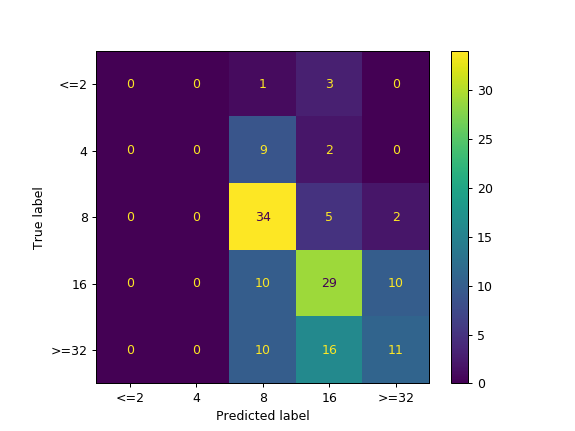

In [292]:
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

### run Parameter Opt

In [319]:
param_grid = {
    'max_depth':[3, 4, 6, 8, 10], 
    'n_estimators': [20, 50, 100, 200],
    'eta': uniform(loc=0, scale=1),
    'gamma': uniform(loc=0, scale=100),
    'min_child_weight': uniform(loc=0, scale=10),
    ''
}

In [320]:
xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0)

In [321]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [322]:
clf = RandomizedSearchCV(xgb_model, param_distributions=param_grid, random_state=rng, cv = kf)

In [323]:
search = clf.fit(X, y)
search.best_params_
search.best_score_

[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.2719582886878314

[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

<IPython.core.display.Javascript object>


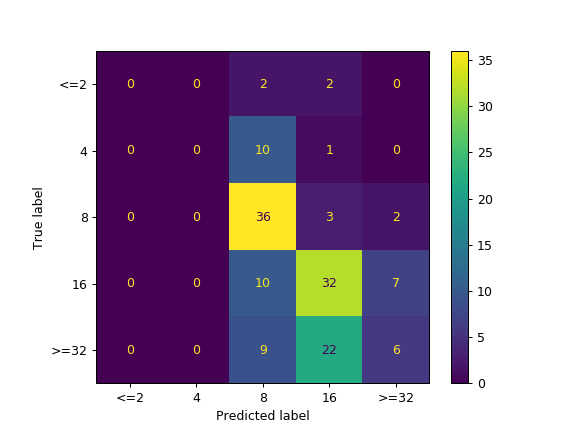

In [324]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, **search.best_params_).fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)
    
print(mean_squared_error(tot_actuals, tot_predictions))
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

In [318]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)